This blog is an introduction to two python modules, `msprime` (by Jerome Kelleher) and `scikit-allel` (by Alistair Miles), both of whom are based in Oxford at the [Big Data Institute](https://www.bdi.ox.ac.uk/). They are both really great tools, and if you work with genomic data I would encourage you to take a look at them.

However, the particular point I'd like to make here is that they work *really* nicely together. 

[msprime](https://msprime.readthedocs.io/en/stable/) is a coalescent simulator with a python interface, essentially an efficient version of `ms`, that also writes data in a sensible format, a compressed sequence tree rather than text files that need to be parsed (which are the bane of bioinformaticians).

[scikit-allel](https://scikit-allel.readthedocs.io/en/latest/) is a toolkit for working with genomic data. Crucially it abstracts data chunking and compression allowing handling of extremely large datasets on a desktop machine. It has a wealth of functions, and is very fast.

It's easy to imagine taking several days to construct and debug an `ms` command, parse the results into something `plink` can work with, compute summary statistics, then parse that into a format appropriate for a plotting library. What I will show here is that this is possible in a few very readable lines of python.

Writing your own parsing code is prone to bugs, even for experienced coders. It's almost invariably inefficient, and harder to maintain/reproduce when you have several tools in your chain.

## Here comes some code...

We begin as usual by importing some essential libraries. As well as the two that are the subject of this blog, we use `numpy` to create a format from `msprime` that `allel` can understand, `pandas` for handling tabular data, and the `seaborn` wrapper to `matplotlib` for plotting.

In [1]:
import allel
import msprime
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
assert msprime.__version__ == "0.4.0"
assert allel.__version__ == "1.1.9"

### Overview

The task I am going to work though is to simulate two populations, with different demographic histories, and see how genome summary statistics differ.

- We'll draw 100 samples from a population size of 1000. Both populations have experienced bottlenecks, one very rapid, the other a gradual decline over many generations.

- Population 1 has experienced a crash starting 40 generations ago, until 20 generations ago, declining at 25% per generation.

- Poputation 2 has experienced a 0.5% per generation decline for 1000 generations. Both have been stable for 20 generations.

Obviously here we can specify more complex demographic scenarios as needed!

In [3]:
history_p1 = [
    msprime.PopulationParametersChange(time=20, growth_rate=-0.25, population_id=0),
    msprime.PopulationParametersChange(time=40, growth_rate=0, population_id=0)]

In [4]:
history_p2 = [
    msprime.PopulationParametersChange(time=20, growth_rate=-0.005, population_id=0),
    msprime.PopulationParametersChange(time=1020, growth_rate=0, population_id=0)]

In [5]:
pop_config = [msprime.PopulationConfiguration(
    sample_size=100, initial_size=1000, growth_rate=0)]

`msprime` also has this neat demography debugger feature so we can check the demographic history is as we intended.

In [6]:
dp = msprime.DemographyDebugger(population_configurations=pop_config,
                                demographic_events=history_p1)

dp.print_history()


Epoch: 0 -- 20.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+03    1e+03               0 |     0    

Events @ generation 20.0
   - Population parameter change for 0: growth_rate -> -0.25 

Epoch: 20.0 -- 40.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+03  1.48e+05          -0.25 |     0    

Events @ generation 40.0
   - Population parameter change for 0: growth_rate -> 0 

Epoch: 40.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |1.48e+05 1.48e+05              0 |     0    



In [7]:
dp = msprime.DemographyDebugger(population_configurations=pop_config,
                                demographic_events=history_p2)

dp.print_history()


Epoch: 0 -- 20.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+03    1e+03               0 |     0    

Events @ generation 20.0
   - Population parameter change for 0: growth_rate -> -0.005 

Epoch: 20.0 -- 1020.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+03  1.48e+05         -0.005 |     0    

Events @ generation 1020.0
   - Population parameter change for 0: growth_rate -> 0 

Epoch: 1020.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |1.48e+05 1.48e+05              0 |     0    



This function is the key part, and represents the interface between the two tools. I've tried to explain what's happening in the comments

In [9]:
def growth_dem_model(pop_cfg, dem_hist, length=1e7, mu=3.5e-9, rrate=1e-8, seed=42):

    
    # call to msprime simulate method. This returns a generator of tree sequences. 
    # One gotcha I found is that the object returned is different if you use the num_replicates argument
    tree_sequence = msprime.simulate(
        length=length, recombination_rate=rrate,
        mutation_rate=mu, random_seed=seed, 
        population_configurations=pop_cfg,
        demographic_events=dem_hist)
    
    # print the number of mutations in the trees using an internal method
    print("Simulated ", tree_sequence.get_num_mutations(), "mutations")
    
    # thanks to Jerome for the code here.
    # The best way to do this is to preallocate a numpy array 
    # (or even better the allel.HaplotypeArray), and fill it incrementally: 
    V = np.zeros((tree_sequence.get_num_mutations(), tree_sequence.get_sample_size()),
                 dtype=np.int8)

    for variant in tree_sequence.variants():
        V[variant.index] = variant.genotypes 
    
    # create a haplotype array in allel from numpy arrays of 0s/1s
    # as the dataset is reasonably small there is no need to use the chunking functionality of allel
    gt = allel.HaplotypeArray(V)
    
    # scikit-allel expects integer values here rather than infinite sites model of msprime.
    pos = allel.SortedIndex([int(variant.position) for variant in tree_sequence.variants()])
    
    return gt, pos

We'll use a contig of 10 Mbp, and summarize the data in 10 kbp windows.

In [10]:
contig_length = 10000000
window_size = 10000

In [11]:
%%time
simulations = {"recent_crash": growth_dem_model(pop_config, history_p1, length=contig_length),
               "slow_decline": growth_dem_model(pop_config, history_p2, length=contig_length)}

Simulated  98234 mutations
Simulated  70472 mutations
CPU times: user 1min 54s, sys: 167 ms, total: 1min 54s
Wall time: 1min 54s


Initialize our data frame: create a multi-index from the combinations of the things we are interested in, and tell it how many rows to expect.

In [12]:
mi = pd.MultiIndex.from_product((simulations.keys(), ("pi", "tajimaD", "wattersonTheta")),
                                names=["scenario", "statistic"])

df = pd.DataFrame(columns=mi, index=range(0, contig_length//window_size))

Using the nice indexing features of pandas it's simple to write a loop, and save the data in the appropriate index.

`allel` also returns some other values such as counts, and bin limits, which in this case we are not interested in, so we assign to `_`.

In [13]:
%time
for key, (haps, pos) in simulations.items():
    
    pi, _, _, _ = allel.diversity.windowed_diversity(
        pos, haps.count_alleles(), size=window_size, start=0, stop=contig_length)
    
    df[key, "pi"] = pi
    
    tjd, _, _ = allel.diversity.windowed_tajima_d(
        pos, haps.count_alleles(), size=window_size, start=0, stop=contig_length)
    
    df[key, "tajimaD"] = tjd
    
    watt, _, _, _ = allel.diversity.windowed_watterson_theta(
        pos, haps.count_alleles(), size=window_size, start=0, stop=contig_length)
    
    df[key, "wattersonTheta"] = watt

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [14]:
from IPython.display import HTML

(I haven't yet figured out how to get multi-index tables to look nice in markdown/html- apologies!)

In [15]:
HTML(df.head().to_html(float_format='%.4f'))

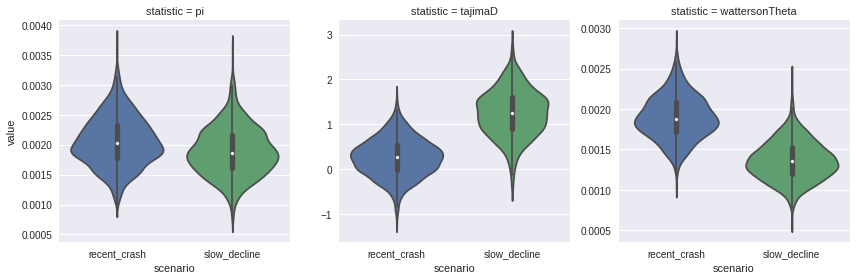

In [16]:
_ = sns.factorplot(x="scenario", y="value", col="statistic", 
                   data=df.melt(), kind="violin", sharey=False)

Thanks for reading this far! Hope something was of use. 